In [17]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from time import time
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import splitfolders
import shutil
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

### Instituto Tecnológico de Costa Rica (ITCR)
### Escuela de Computación
### Curso: Inteligencia Artificial
 
### Projecto 3 parte 1: Red CNN


Profesora: María Auxiliadora Mora

Estudiantes:
 1. Pablo Alberto Muñoz Hidalgo
 2. Luis Andrés Rojas Murillo

Entregables: Un archivo en Jupyter ( .IPYNB ). 

Modo de trabajo: En parejas.

---

Objetivo: Comprender de forma completa el funcionamiento y las dinámicas de trabajo que se utilizan en la implementación de estas redes convolucionales además de conocer el proceso de configuracion establecido para el adecuado funcionamiento con una muestra dada.

Problema: se establece una muestra de imagenes pertenecientes a aves de distintas especies las cuales ya se dan clasificadas y etiquetas sin embargo la función que viene a desempeñar el algoritmo es reclasificar las mismas de acuerdo a la clasificación de imagenes.

### Referencia de los datos

Los datos utilizados se pueden definir como una colección de imagenes que aves que se deben de clasificar de acuedo a su especie.

Fuente:
- BIRDS 525 SPECIES- IMAGE CLASSIFICATION:
https://www.kaggle.com/datasets/gpiosenka/100-bird-species

### Sección de carga, normalización y exploración los datos.

In [18]:
#reduce the images quality to 3x32x32
transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Número de imágenes de entrenamiento:  25479
Número de imágenes de prueba:  800



IMAGEN A RESOLUCION 48x48


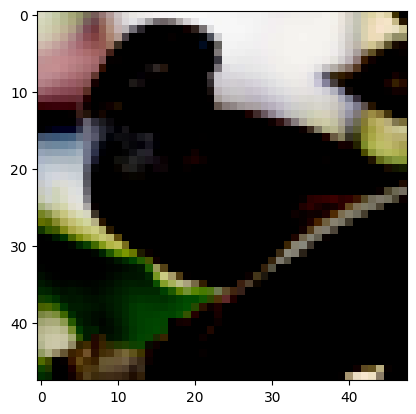

In [19]:
# Define la ruta a la carpeta que contiene las imágenes
ruta_imagenes = "birds"

# Carga de los datos de la ruta imagenes, crea un set de training con la carpeta train, luego uno de testing con la carpeta test
# y por último uno de validación con la carpeta val
testset = datasets.ImageFolder(ruta_imagenes + "/test", transform=transform)
trainset = datasets.ImageFolder(ruta_imagenes + "/train", transform=transform)


# Se definen objetos para la carga de los datos en mini batches (DataLoader),
# que combinan y barajan el conjunto de datos. 

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

#Normaliza los datos para ser procesados

# Imprime el número de imágenes y clases en el conjunto de datos
print("Número de imágenes de entrenamiento: ", len(trainset))
print("Número de imágenes de prueba: ", len(testset))

#imprime lcualquier imagen del set de prueba
print('\n\n\nIMAGEN A RESOLUCION 48x48')
plt.imshow(trainset[0][0].permute(1, 2, 0))
plt.show()


### Analisis de las imagenes 
Se concluye que el conjunto de imagenes para la prueba es una coleccion de imagenes representativas de especies animales clasificadas según su especie en directorios especificos los cuales se utilizarán para una clasificcaion automática a travéz del perceptrón.

### Estadísticas

In [20]:
# Genera estadísticas del conjunto de datos
etiquetas = [etiqueta for _, etiqueta in testset]
etiquetas_dict = {clase: etiquetas.count(indice_clase) for indice_clase, clase in enumerate(testset.classes)}

# Estadísticas 1: Cantidad de registros por clase
# Se almacena en un diccionario la clase con su respectiva incidencia en el conjunto de datos
incidencias = {clase: etiquetas.count(indice_clase) for indice_clase, clase in enumerate(testset.classes)}



##### Distribución de imagenes por cada clase 

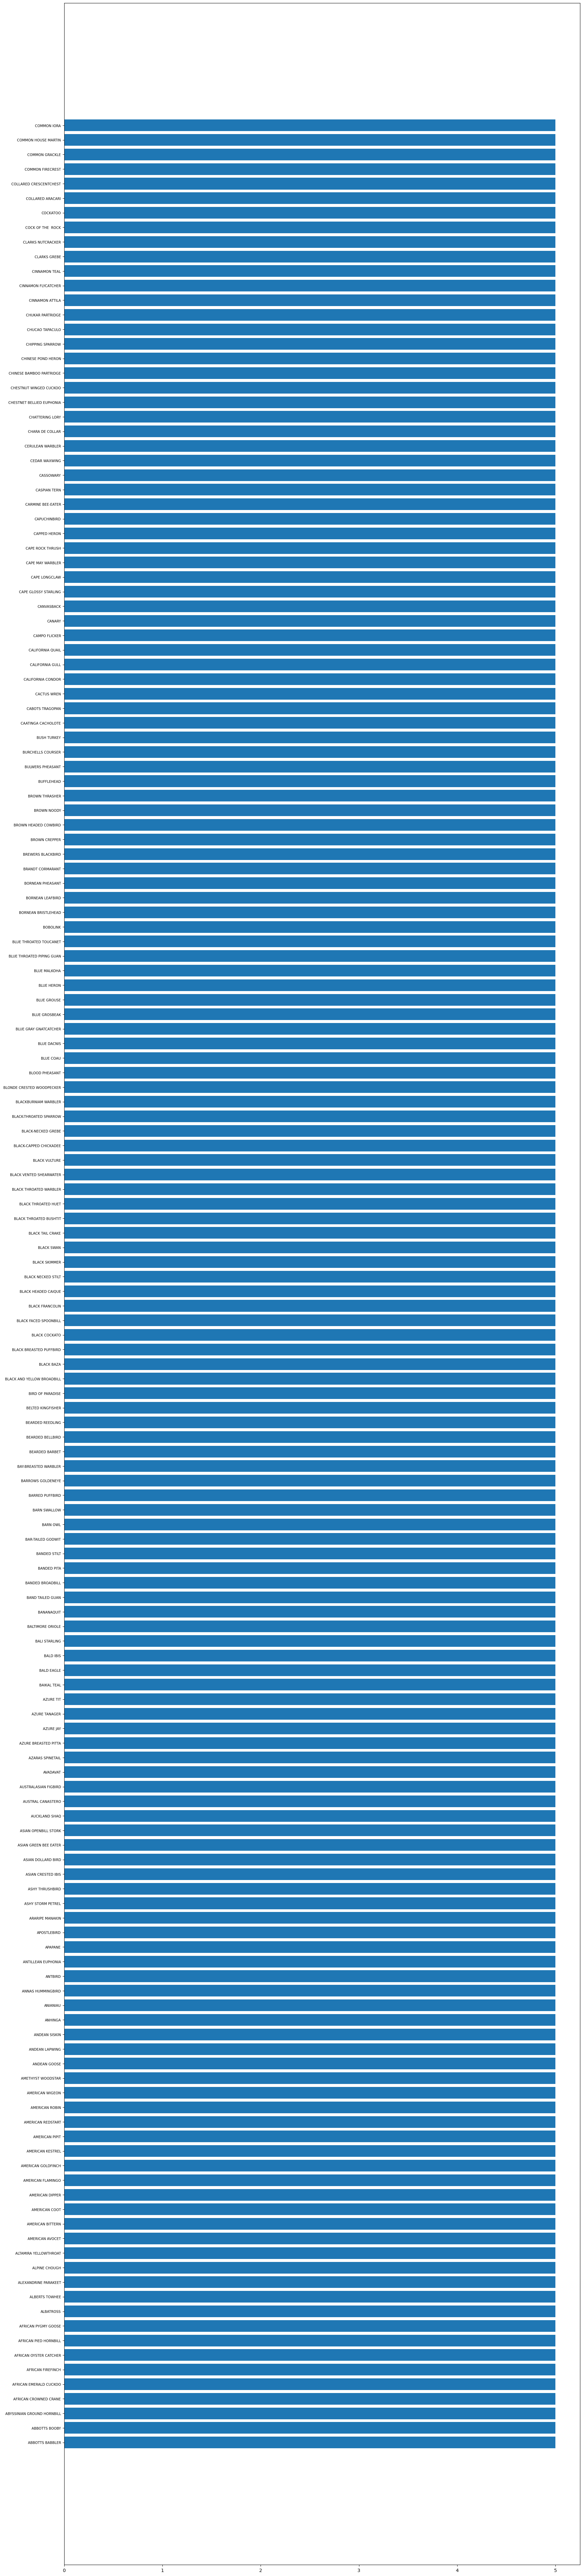

                          Clase  Incidencia
0               ABBOTTS BABBLER           5
1                 ABBOTTS BOOBY           5
2    ABYSSINIAN GROUND HORNBILL           5
3         AFRICAN CROWNED CRANE           5
4        AFRICAN EMERALD CUCKOO           5
..                          ...         ...
155      COLLARED CRESCENTCHEST           5
156            COMMON FIRECREST           5
157              COMMON GRACKLE           5
158         COMMON HOUSE MARTIN           5
159                 COMMON IORA           5

[160 rows x 2 columns]


In [21]:
# se grafican las incidencias con los nombres de las claces en forma vertical y con una funete muy pequeña
#Do a graphic for 525 classes
plt.figure(figsize=(20, 100))
plt.barh(list(incidencias.keys()), list(incidencias.values()))
plt.yticks(fontsize=7.5)
plt.show()


#haga una tabla con las incidencias de cada clase usando pandas
df = pd.DataFrame(incidencias.items(), columns=['Clase', 'Incidencia'])
print(df)   


### Definición de la red convolucional.

In [22]:
print('\n\n\nTamaño y datos generales del trainloader 48x48')
print(trainloader.dataset[-1][0].shape)
#print('\n\n\nTamaño y datos generales del trainloader 128x128')
#print(trainloader_hd.dataset[-1][0].shape)





Tamaño y datos generales del trainloader 48x48
torch.Size([3, 48, 48])


In [23]:


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
        
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        
        self.flat = nn.Flatten()
        
        self.fc3 = nn.Linear(32 * 24 * 24, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
        
        #Cantidad de clases 90
        self.fc4 = nn.Linear(512, 525)
    
    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        x = self.flat(x)
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        x = self.fc4(x)
        return x

model = CNN()
print(model)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

#Iteraciones
epochs = 50
results = {}
#se agrega a results un apartado para train values y test values
results['train'] = []
results['test'] = []
loss = []
#Print the time it takes to run it
start_time = time.time()
for epoch in range(epochs):
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    results["train"].append([(epoch+1),loss.detach().numpy()])
    acc = 0
    count = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs)
            acc += (torch.argmax(outputs, 1) == labels).float().sum()
            count += len(labels)
            #Get the loss from test loadre
            loss_test = criterion(outputs, labels)
        acc /= count
    results["test"].append([(epoch+1),loss_test.detach().numpy(), ((acc/count).detach().numpy()*100)])
    print("Epoch: {}/{}.. ".format(epoch+1, epochs), 
            "Training Loss: {:.3f}.. ".format(loss.detach().numpy()),
            "Test Accuracy: {:.3f}%".format((acc/count).detach().numpy()*10000))

print("\n--- %s seconds ---" % (time.time() - start_time))
torch.save(model.state_dict(), 'cifar10_model.pth')


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (drop1): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc3): Linear(in_features=18432, out_features=512, bias=True)
  (act3): ReLU()
  (drop3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=512, out_features=525, bias=True)
)
Epoch: 1/50..  Training Loss: 4.984..  Test Accuracy: 0.281%
Epoch: 2/50..  Training Loss: 4.229..  Test Accuracy: 0.828%
Epoch: 3/50..  Training Loss: 3.739..  Test Accuracy: 2.250%
Epoch: 4/50..  Training Loss: 3.772..  Test Accuracy: 2.531%
Epoch: 5/50..  Training Loss: 2.740..  Test Accuracy: 2.797%
Epoch: 6/50..  Training Loss: 2.563..  Test Accuracy: 3.484%
Epoch: 7/50..  Training Loss: 3.388..  Test Accuracy: 3.734%
Epoch: 8/50..  

Muestra de los resultados obtenidos

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

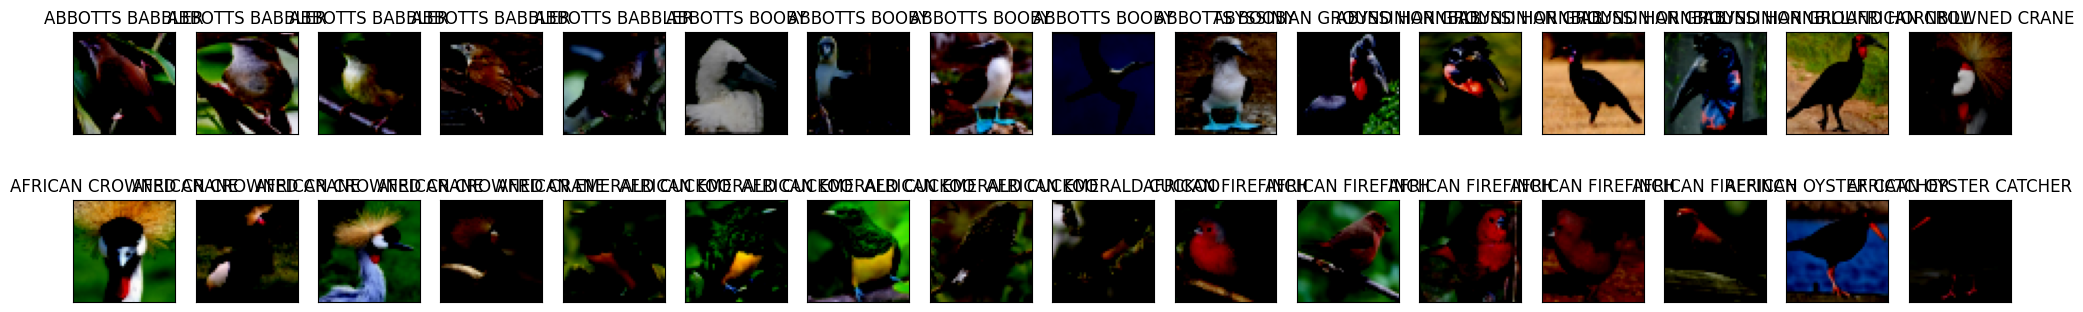

In [24]:
#Clases asociadas a las imágenes.
classes = testloader.dataset.classes

dataiter = iter(testloader)
images, labels = next(dataiter)


# Se muestran las imágenes de prueba, muestra 100 imagenes y sus predicciones de manera ordenada en una tabla
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(32):
    ax = fig.add_subplot(2, 32//2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])
plt.show()

## Analisis de resultados

Resultados con imagenes de 48x48

    Época  % Perdida  % Exactitud
0       1  4.9235487     0.281250
1       2  3.9400623     0.828125
2       3  3.9787507     2.250000
3       4  3.3576496     2.531250
4       5  3.2247834     2.796875
5       6  2.6737905     3.484375
6       7  2.7940779     3.734375
7       8  2.9337783     4.578125
8       9  2.7828784     4.750000
9      10  2.5675354     4.578125
10     11   2.504825     5.000000
11     12  2.5104134     5.000000
12     13  2.4357564     5.281250
13     14  2.3133216     5.468750
14     15  2.4780052     5.343750
15     16  2.0002618     5.531250
16     17  2.3742974     5.796875
17     18   2.677096     5.828125
18     19  2.4506032     5.812500
19     20   2.665724     5.468750
20     21  2.4091089     5.750000
21     22  2.4175208     5.953125
22     23   2.953532     5.703125
23     24  3.4641495     5.109375
24     25  3.2598438     5.718750
25     26   3.176342     5.609375
26     27  2.9203568     5.859375
27     28  3.5365462     5.843750
28     29   3.

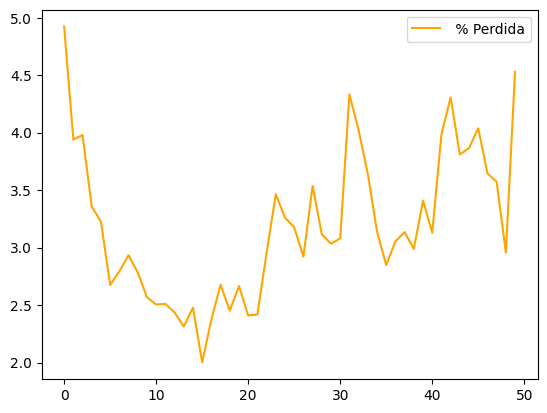

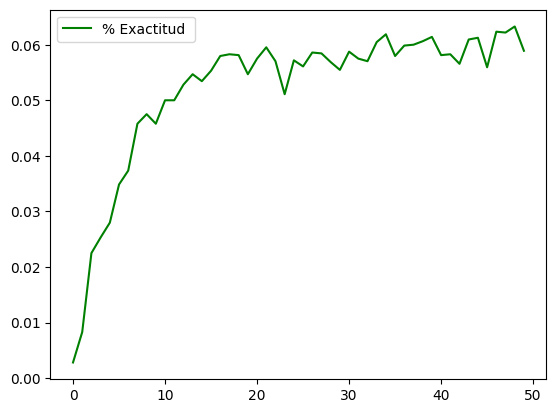


Classification Report:
                            precision    recall  f1-score   support

           ABBOTTS BABBLER       0.33      0.20      0.25         5
             ABBOTTS BOOBY       0.00      0.00      0.00         5
ABYSSINIAN GROUND HORNBILL       0.33      0.20      0.25         5
     AFRICAN CROWNED CRANE       1.00      0.20      0.33         5
    AFRICAN EMERALD CUCKOO       1.00      0.40      0.57         5
         AFRICAN FIREFINCH       0.80      0.80      0.80         5
    AFRICAN OYSTER CATCHER       0.67      0.40      0.50         5
     AFRICAN PIED HORNBILL       0.60      0.60      0.60         5
       AFRICAN PYGMY GOOSE       0.60      0.60      0.60         5
                 ALBATROSS       0.40      0.40      0.40         5
            ALBERTS TOWHEE       0.67      0.40      0.50         5
      ALEXANDRINE PARAKEET       0.67      0.80      0.73         5
             ALPINE CHOUGH       0.50      0.20      0.29         5
     ALTAMIRA YELLOWTHR

In [25]:

#se hace una tabla con las columnas marcadas con los tensores de loss y accuracy
df = pd.DataFrame(results['test'], columns=['Época', '% Perdida', '% Exactitud'])
#multiplica la exactitud por 1000
df['% Exactitud'] = df['% Exactitud'] * 100
print(df)
#se calcula el recall
recall = df['% Exactitud'].mean()

#impresion de datos: Accuracy, Precision, Recall y F1.
test_results = np.array(results["test"])

print('Accuracy: ', (acc/count).detach().numpy()*10000)
print('Precision: ', test_results[-1][2])
print('Recall: ', recall)


#se calcula la f1
f1 = 2 * (recall *  test_results[-1][2]) / (recall +  test_results[-1][2])
print('F1: ', f1)



#se grafican los tensores de loss y accuracy por separado

plt.plot(test_results[:, 1], label=' % Perdida', color='orange')
plt.legend()
plt.show()


plt.plot(test_results[:, 2], label='% Exactitud ', color= 'green')
plt.legend()
plt.show()


def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalized confusion matrix

    plt.figure(figsize=(len(labels), len(labels)))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=labels))

#calcule estos parametros 
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in testloader:
        outputs = model(inputs)
        y_pred.extend(torch.argmax(outputs, 1).tolist())
        y_true.extend(labels.tolist())

plot_confusion_matrix(y_true, y_pred, classes)


##### Analisis de la matriz de confusión

La matriz de confusion nos presenta una vista de resultados un poco mas orientadora y clara, ya nos provee que tan cerca estan los resultados de las predicciones de nuestra red convolucional.
Ya analizando los resultados se denota una tendencia a resultados correctos mas sin embargo existe una dispersión considerable en las predicciones la cual consideramos que podría tender a la baja en el caso de que aumente la cantidad de épocas de analisis por parte de la red 



##### Curva de error 

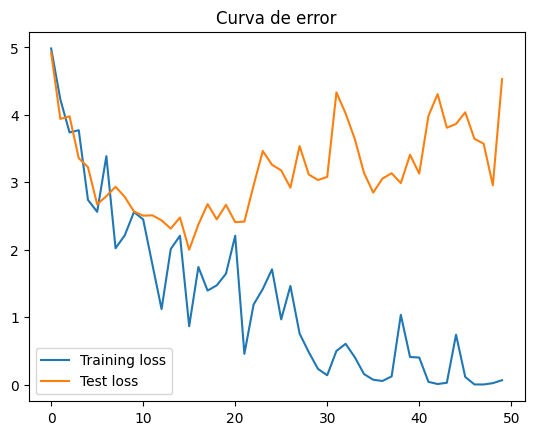

In [26]:

#genera una grafica que compare el margen de error con los datos de train y test
def plot_results(results):
    train_loss = [x[1] for x in results['train']]
    test_loss = [x[1] for x in results['test']]
    plt.title('Curva de error')
    plt.plot(train_loss, label='Training loss')
    plt.plot(test_loss, label='Test loss')
    plt.legend()
    plt.show()


plot_results(results)





La curva de error da a entender que conforme pasan las épocas el rate de perdida disminuye por lo que se podría creer que entre más épocas pasen más refinado se vuelve el algoritmo, sin embargo existe la posibilidad de que tenga un comportamiento logaritmico el cual la reducción de error por época sea minima. 

Para la prueba con (10 épocas) el rate disminuyó a más de la mitad.

Para la prueba con (50 épocas) el rate disminuyó a más de cinco veces su número inicial.

#### Proposicion de mejoras

1. Buscar un método de optimizar estos algoritmos para disminuir el consumo de recursos y minimizar la duracion de la ejecución
2. Se puede aumentar el numero de epocas para asi poder permitir al perceptron desarrollar mejor sus habilidades 

#### Cambios aplicados para la mejora del flujo 

1. Se disminuyó el tamaño de la muesta a un numero mucho menor de clases para clasificar lo que alivió fuertemente las necesidades de procesamineto sin embargo si se comprobó que el algoritmo es capaz de clasificar la colección de imagenes completa. 
2. Se disminuyo la resolucion de las imagenes que compuso un claro avance para el aumento de la velocidad de procesamiento aunque afectando la efectividad de los analisis 
3. Se aplicaron corridas con diferente cantidades de épocas de procesamineto sin embargo quedó demostrado que entre más épocas se aplique aumenta la fiabilidad del modelo.

Todas esta endidas fueron parte de las experimentaciones realizadas.

## Conclusiones


1. La configuracion de los múltiples paramentros de analisis es crucial para el correcto funcionamiento del mecanismo del perceptrón.
2. Las Redes Cerebrales Convolucionales (CNN) han demostrado una ejecución inigualable en tareas de ordenación de imágenes en comparación con los cálculos habituales de IA.
3. Las capas convolucionales de las CNN utilizan operaciones de campo receptivo local para aprender características invariantes y captar las relaciones espaciales entre píxeles. Esta capacidad permite a las CNN adaptarse bien a imágenes ocultas y manejar las variedades genuinas que se dan en aplicaciones útiles.
4. Las CNN pueden extraer directamente características de bajo y alto nivel a partir de datos de imágenes sin procesar mediante el aprendizaje de representaciones jerárquicas de características a través de capas convolucionales.

## Referencias
[1] Krajewski, J. (2020). PyTorch layer dimensions: what size and why?. Recuperado de https://towardsdatascience.com/pytorch-layer-dimensions-what-sizes-should-they-be-and-why-4265a41e01fd

[2] Recommended approach for saving a model. <https://pytorch.org/docs/stable/notes/serialization.html>

[3] Krizhevsky, A., Nair, G, & Hinton, G. The CIFAR-10 dataset (n.d.).  Recuperado de https://www.cs.toronto.edu/~kriz/cifar.html

[4] Tam, Adrian (2023). Building a Convolutional Neural Network in PyTorch. Recuperado de https://machinelearningmastery.com/building-a-convolutional-neural-network-in-pytorch/